Train: ISOT + ReCOVery + FA-KES

Test: ISOT, ReCOVery, FA-KES (individually)

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12219789761793609617
]


In [3]:
true = pd.read_csv("../Datasets/ISOT/True.csv", dtype=str)
fake = pd.read_csv ("../Datasets/ISOT/Fake.csv", dtype=str)
true.head()
fake.head()

,title,text,subject,date,label,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
true = true.loc[:, ~true.columns.str.contains('^Unnamed')]
fake = fake.loc[:, ~fake.columns.str.contains('^Unnamed')]
fake = fake.drop(columns=fake.columns[0])
fake = fake.drop(columns=fake.columns[1])
fake = fake.drop(columns=fake.columns[1])
true = true.drop(columns=true.columns[0])
true = true.drop(columns=true.columns[1])
true = true.drop(columns=true.columns[1])

In [5]:
true = shuffle(true, random_state=0)
fake = shuffle(fake, random_state=0)

In [6]:
truetrainpercentage = round(len(true)*0.8)
truetotal = len(true)
faketrainpercentage = round(len(fake)*0.8)
faketotal = len(fake)

In [7]:
truetrain = true[0:truetrainpercentage]
truetest = true[truetrainpercentage:truetotal]
faketrain = fake[0:faketrainpercentage]
faketest = fake[faketrainpercentage:faketotal]

In [8]:
isottestframes = [truetest, faketest]
isottest = pd.concat(isottestframes)
isottest = shuffle(isottest, random_state=0)

In [9]:
truetest

,text,label
1200,WASHINGTON (Reuters) - The U.S. Federal Commun...,1
13031,BRUSSELS (Reuters) - Turkish Foreign Minister ...,1
11308,HARARE (Reuters) - Retired army chief Constant...,1
1192,"GREENBELT, Md. (Reuters) - A U.S. judge on Mon...",1
14613,KABUL (Reuters) - A suicide bomb attack in the...,1
...,...,...
13123,CAIRO (Reuters) - Former Egyptian interior min...,1
19648,KHARTOUM (Reuters) - Sudanese President Omar a...,1
9845,RIYADH (Reuters) - U.S. President Barack Obama...,1
10799,WASHINGTON (Reuters) - Former White House nati...,1


In [10]:
fa_kes = pd.read_csv("../Datasets/FA-KESDataset/FA-KES-Dataset.csv")
recovery = pd.read_csv("../Datasets/ReCOVery/recovery-news-data.csv")

In [11]:
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[2])
fa_kes

,text,label
0,Wed 05 Apr 2017 Syria attack symptoms consiste...,0
1,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,0
2,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,0
3,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,0
4,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,0
...,...,...
799,28-08-2016 Turkish Bombardment Kills 20 Civili...,1
800,17-08-2016 Martyrs as Terrorists Shell Aleppos...,1
801,03-08-2016 Chemical Attack Kills Five Syrians ...,0
802,01-08-2016 5 Killed as Russian Military Choppe...,1


In [12]:
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[1])
recovery = recovery.drop(columns=recovery.columns[1])
recovery

,text,label
0,\nA novel respiratory virus that originated in...,1
1,Chinese Health Officials: More Die From Newly ...,1
2,Public health experts around the globe are scr...,1
3,The first two coronavirus cases in Europe have...,0
4,"A new coronavirus appeared in Wuhan, China, at...",1
...,...,...
2024,© Robert Gauthier/Los Angeles Times/TNS People...,0
2025,"Michael Moore, for decades on the political fr...",0
2026,© HEATHER KHALIFA/The Philadelphia Inquirer/TN...,0
2027,Nearly half of the Twitter accounts sharing in...,0


In [13]:
fa_kes = shuffle(fa_kes, random_state=0)
recovery = shuffle(recovery, random_state=0)

In [14]:
recoverytrainpercentage = round(len(recovery)*0.8)
recoverytotal = len(recovery)

recoverytrain = recovery[0:recoverytrainpercentage]
recoverytest = recovery[recoverytrainpercentage:recoverytotal]

fa_kestrainpercentage = round(len(fa_kes)*0.8)
fa_kestotal = len(fa_kes)

fa_kestrain = fa_kes[0:fa_kestrainpercentage]
fa_kestest = fa_kes[fa_kestrainpercentage:fa_kestotal]

In [15]:
trainframes = [fa_kestrain]
train = pd.concat(trainframes)
train = shuffle(train, random_state=0)

In [16]:
train.head(5)

,text,label
117,Date of publication 20 June 2016 An Islamic St...,1
251,Rebel fire kills 3 Aleppo schoolchildren state...,1
59,30 Apr 2017 White Helmets operates in the oppo...,1
688,Kurdish SDF Kills 23 Daesh Militants as Part o...,0
473,Wednesday 03 May 2017 22:35 Syrian Coalition C...,0


In [17]:
train

,text,label
117,Date of publication 20 June 2016 An Islamic St...,1
251,Rebel fire kills 3 Aleppo schoolchildren state...,1
59,30 Apr 2017 White Helmets operates in the oppo...,1
688,Kurdish SDF Kills 23 Daesh Militants as Part o...,0
473,Wednesday 03 May 2017 22:35 Syrian Coalition C...,0
...,...,...
150,More than 30 Syrian rebels killed in IS group ...,0
125,Date of publication 3 October 2017 Internation...,0
200,Syria air strikes kill 10 children 5 women in ...,0
287,Last updated at Apr 052017 KHAN SHEIKHUN Syria...,1


In [18]:
import spacy
spacy.load('en_core_web_sm')

In [19]:
#!pip install spacy== 3.0.0
#!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\helen\AppData\Local\Temp\pip-req-build-0mctv7u1'



  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\helen\appdata\local\temp\pip-req-build-0mctv7u1
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7692 sha256=b23a8293062a5adca1473a1c92fcf4234fa0f60b5f9da9bc63b2073e7995367c
  Stored in directory: C:\Users\helen\AppData\Local\Temp\pip-ephem-wheel-cache-bqtsgg0j\wheels\cd\26\af\103cfac199bd773bfc95ed85a52fe9095e4d902ed9ac3b0c97
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [20]:
import preprocess_kgptalkie as ps

In [21]:
recoverytest

,text,label
800,Chongqing Medical University China has found t...,0
281,"According to the Korean CDC, COVID-19 may be r...",0
932,Trump has long relied on cronies who flatter h...,1
732,"""The Russians are coming!"" In April 1945, the ...",0
715,The city on Friday outlined the rules for each...,1
...,...,...
835,You don’t know what you’ve got till it’s gone....,0
1216,The German response to the coronavirus has led...,1
1653,Recruited by a member of a Palestinian terrori...,0
559,Chicagoans who have a burning curiosity to kno...,1


In [22]:
train['text'] = train['text'].apply(lambda x: str(x).lower())
isottest['text'] = isottest['text'].apply(lambda x: str(x).lower())
fa_kestest['text'] = fa_kestest['text'].apply(lambda x: str(x).lower())
recoverytest['text'] = recoverytest['text'].apply(lambda x: str(x).lower())

train['text'] = train['text'].apply(lambda x: ps.remove_special_chars(x))
isottest['text'] = isottest['text'].apply(lambda x: ps.remove_special_chars(x))
fa_kestest['text'] = fa_kestest['text'].apply(lambda x: ps.remove_special_chars(x))
recoverytest['text'] = recoverytest['text'].apply(lambda x: ps.remove_special_chars(x))

C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\helen\anaconda3\envs\fakenews\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on 

In [23]:
fa_kes

,text,label
8,Sun 01 Feb 2015 Explosion rocks down town Dama...,1
575,Thu Feb 26 2015 ISIS Begins to kill Abducted C...,0
616,Wed Mar 2 2016 18 Militants Killed in Car Bomb...,1
142,US-backed Syrian fighters pressing IS gunmen i...,1
236,Syria rebels kill 7 in Aleppo assault capture ...,1
...,...,...
763,29062016 7 civilians killed 25 injured in terr...,0
192,suicide bomber kills six in syria restaurant r...,1
629,sat nov 12 2016 2 killed 10 injured in terrori...,1
559,wednesday 16 november 2016 syrian russian jets...,1


In [24]:
trainx = [d.split() for d in train['text'].tolist()]
trainy = train['label'].values

isotx = [d.split() for d in isottest['text'].tolist()]
isoty = isottest['label'].values

fa_kestestx = [d.split() for d in fa_kestest['text'].tolist()]
fa_kestesty = fa_kestest['label'].values

recoverytestx = [d.split() for d in recoverytest['text'].tolist()]
recoverytesty = recoverytest['label'].values

In [25]:
isoty

array(['1', '1', '1', ..., '0', '1', '1'], dtype=object)

In [26]:
DIM = 400
trainw2v_model = gensim.models.Word2Vec(sentences=trainx, vector_size=DIM, window=10, min_count=1)

isotw2v_model = gensim.models.Word2Vec(sentences=isotx, vector_size=DIM, window=10, min_count=1)

fa_kesw2v_model = gensim.models.Word2Vec(sentences=fa_kestestx, vector_size=DIM, window=10, min_count=1)

recoveryw2v_model = gensim.models.Word2Vec(sentences=recoverytestx, vector_size=DIM, window=10, min_count=1)

# size --> vector_size

In [27]:
print(len(trainw2v_model.wv.key_to_index))

print(len(isotw2v_model.wv.key_to_index))

print(len(fa_kesw2v_model.wv.key_to_index))

print(len(recoveryw2v_model.wv.key_to_index))

9885
94160
5304
28115


In [28]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(trainx)

tokenizer.fit_on_texts(isotx)

tokenizer.fit_on_texts(fa_kestestx)

tokenizer.fit_on_texts(recoverytestx)

In [29]:
trainx = tokenizer.texts_to_sequences(trainx)

isotx = tokenizer.texts_to_sequences(isotx)

fa_kestestx = tokenizer.texts_to_sequences(fa_kestestx)

recoverytestx = tokenizer.texts_to_sequences(recoverytestx)

train


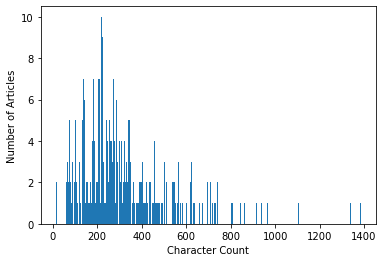

In [30]:
plt.hist([len(a) for a in trainx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("train")
plt.show()

isot


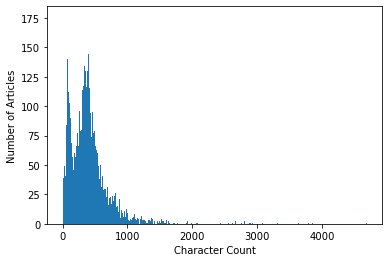

In [31]:
plt.hist([len(a) for a in isotx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("isot")
plt.show()

fa_kes


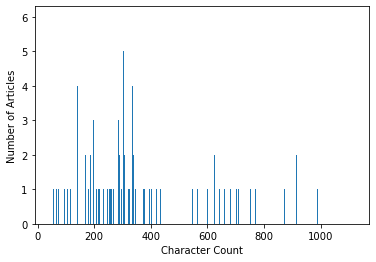

In [32]:
plt.hist([len(a) for a in fa_kestestx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("fa_kes")
plt.show()

recovery


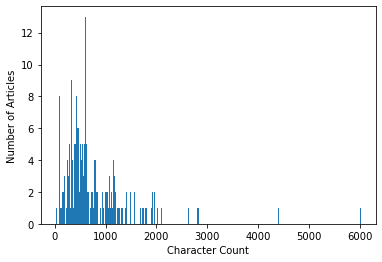

In [33]:
plt.hist([len(a) for a in recoverytestx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("recovery")
plt.show()

In [34]:
trainnos = np.array([len(a) for a in trainx])
len(trainnos[trainnos>1000])

isotnos = np.array([len(a) for a in isotx])
len(isotnos[isotnos>1000])

fa_kesnos = np.array([len(a) for a in fa_kestestx])
len(fa_kesnos[fa_kesnos>1000])

recoverynos = np.array([len(a) for a in recoverytestx])
len(recoverynos[recoverynos>1000])

100

In [35]:
maxlen = 100
trainx = tf.keras.preprocessing.sequence.pad_sequences(trainx, maxlen=maxlen)

isotx = tf.keras.preprocessing.sequence.pad_sequences(isotx, maxlen=maxlen)

fa_kestestx = tf.keras.preprocessing.sequence.pad_sequences(fa_kestestx, maxlen=maxlen)

recoverytestx = tf.keras.preprocessing.sequence.pad_sequences(recoverytestx, maxlen=maxlen)

In [36]:
trainvocab_size = len(tokenizer.word_index) + 1
trainvocab = tokenizer.word_index

isotvocab_size = len(tokenizer.word_index) + 1
isotvocab = tokenizer.word_index

fa_kestestvocab_size = len(tokenizer.word_index) + 1
fa_kestestvocab = tokenizer.word_index

recoveryvocab_size = len(tokenizer.word_index) + 1
recoveryvocab = tokenizer.word_index

In [37]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((trainvocab_size, DIM))
    
    for word, i in trainvocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [38]:
embedding_vectors = get_weight_matrix(trainw2v_model)

whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
whatever
w

In [39]:
embedding_vectors.shape

(108292, 400)

In [40]:
testx = np.concatenate((isotx, recoverytestx, fa_kestestx))
testy = np.concatenate((isoty, recoverytesty, fa_kestesty))

testx = shuffle(testx, random_state = 60)
testy = shuffle(testy, random_state = 60)

In [41]:
trainy = trainy.astype(int)
testy = testy.astype(int)

In [42]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
print(imblearn.__version__)

oversample = RandomOverSampler(sampling_strategy='auto')
trainx, trainy = oversample.fit_resample(trainx, trainy)
testx, testy = oversample.fit_resample(testx, testy)

0.8.1


In [43]:
model = Sequential()

model.add(Embedding(trainvocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(8, 5, activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid")) 
model.add(LSTM(2))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 400)          43316800  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 8)             16008     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 8)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 2)                 88        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 43,332,899
Trainable params: 16,099
Non-trainable params: 43,316,800
_________________________________________________________________


In [44]:
len(trainx)

678

In [45]:
trainx = np.asarray(trainx).astype(np.float32)
trainy = np.asarray(trainy).astype(np.float32)

isotx = np.asarray(isotx).astype(np.float32)
isoty = np.asarray(isoty).astype(np.float32)

fa_kestestx = np.asarray(fa_kestestx).astype(np.float32)
fa_kestesty = np.asarray(fa_kestesty).astype(np.float32)

recoverytestx = np.asarray(recoverytestx).astype(np.float32)
recoverytesty = np.asarray(recoverytesty).astype(np.float32)

testx = np.asarray(testx).astype(np.float32)
testy = np.asarray(testy).astype(np.float32)

In [76]:
model.fit(trainx, trainy, epochs=10, batch_size=64)

Epoch 1/10
11/11 [==============================] - 1s 84ms/step - loss: 0.6227 - accuracy: 0.7139 - recall: 0.7493 - precision: 0.6997 - true_negatives: 230.0000 - true_positives: 254.0000 - false_positives: 109.0000 - false_negatives: 85.0000
Epoch 2/10
11/11 [==============================] - 1s 75ms/step - loss: 0.6196 - accuracy: 0.7242 - recall: 0.7847 - precision: 0.7000 - true_negatives: 225.0000 - true_positives: 266.0000 - false_positives: 114.0000 - false_negatives: 73.0000
Epoch 3/10
11/11 [==============================] - 1s 75ms/step - loss: 0.6168 - accuracy: 0.7212 - recall: 0.7640 - precision: 0.7038 - true_negatives: 230.0000 - true_positives: 259.0000 - false_positives: 109.0000 - false_negatives: 80.0000
Epoch 4/10
11/11 [==============================] - 1s 77ms/step - loss: 0.6151 - accuracy: 0.7271 - recall: 0.7493 - precision: 0.7175 - true_negatives: 239.0000 - true_positives: 254.0000 - false_positives: 100.0000 - false_negatives: 85.0000
Epoch 5/10
11/11 [==

In [77]:
model.evaluate(isotx, isoty)

281/281 [==============================] - 4s 15ms/step - loss: 0.7508 - accuracy: 0.4536 - recall: 0.7614 - precision: 0.4563 - true_negatives: 814.0000 - true_positives: 3261.0000 - false_positives: 3886.0000 - false_negatives: 1022.0000


[0.7508336901664734,
 0.453634649515152,
 0.7613822221755981,
 0.4562753736972809,
 814.0,
 3261.0,
 3886.0,
 1022.0]

In [78]:
model.evaluate(recoverytestx, recoverytesty)

13/13 [==============================] - 0s 17ms/step - loss: 0.6542 - accuracy: 0.6379 - recall: 0.8175 - precision: 0.6978 - true_negatives: 35.0000 - true_positives: 224.0000 - false_positives: 97.0000 - false_negatives: 50.0000


[0.6542118787765503,
 0.6379310488700867,
 0.8175182342529297,
 0.6978192925453186,
 35.0,
 224.0,
 97.0,
 50.0]

In [79]:
model.evaluate(fa_kestestx, fa_kestesty)

6/6 [==============================] - 0s 17ms/step - loss: 0.6998 - accuracy: 0.5217 - recall: 0.5517 - precision: 0.5581 - true_negatives: 36.0000 - true_positives: 48.0000 - false_positives: 38.0000 - false_negatives: 39.0000


[0.699754536151886,
 0.52173912525177,
 0.5517241358757019,
 0.5581395626068115,
 36.0,
 48.0,
 38.0,
 39.0]

In [80]:
model.evaluate(testx, testy)

307/307 [==============================] - 5s 15ms/step - loss: 0.7412 - accuracy: 0.4713 - recall: 0.7621 - precision: 0.4818 - true_negatives: 885.0000 - true_positives: 3739.0000 - false_positives: 4021.0000 - false_negatives: 1167.0000


[0.7412416338920593,
 0.4712596833705902,
 0.7621279954910278,
 0.4818299114704132,
 885.0,
 3739.0,
 4021.0,
 1167.0]